In [2]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import load_database, save_database, filter_data
# Set up the system path to include parent directory
sys.path.append('../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)

def load_rules(rules_path, formula_key='Composition', element_key='C', min_count=0, max_count=0):
    """
    Loads and filters a set of rules from a specified path based on the given parameters.

    The function first loads a database of rules from the given path. It then filters 
    this data based on the specified element's count within a chemical formula.

    Parameters:
    - rules_path: str
        The file path to the rules database to be loaded.
    - formula_key: str, optional (default='Composition')
        The key in the database that corresponds to the chemical composition.
    - element_key: str, optional (default='C')
        The specific element to focus on within the chemical compositions.
    - min_count: int, optional (default=0)
        The minimum count of the specified element in a composition for a rule to be included.
    - max_count: int, optional (default=0)
        The maximum count of the specified element in a composition for a rule to be included.
        A value of 0 indicates no upper limit.

    Returns:
    - list or DataFrame
        The filtered set of rules based on the specified element counts within their compositions.
    """
    rules = load_database(rules_path)
    rules = filter_data(rules, unbalance_values=None, formula_key=formula_key, element_key=element_key, 
                        min_count=min_count, max_count=max_count)
    return rules


def main():
    """
    Main function to execute script tasks.
    """
    configure_logging()

    # Load data
    #data_file_path = '/homes/biertank/tieu/Documents/Project/SynRBL/Data/USPTO_50K.csv'
    data_file_path = '../Data/USPTO_50K.csv'
    df = load_data(data_file_path)

    # Display the first few rows of the DataFrame
    display(df.head())

    # Print the number of rows in the DataFrame
    print(f"Number of rows in the dataset: {len(df)}")

    # Load rules
    rules = load_rules('../Data/rule_manager.json.gz')
    print('Number of rules: ', len(rules))

    return df, rules


if __name__ == "__main__":
    df, rules = main()

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


Number of rows in the dataset: 50016


ValueError: Error reading to file ../Data/rule_manager.json.gz: [Errno 2] No such file or directory: '../Data/rule_manager.json.gz'

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2}},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccc

# **1. USPTO predcition**

## 1.1. Preprocessing

In [9]:
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.rsmi_utils import  load_database

def process_reactions(input_data):
    """
    Process and rebalance reactions based on the provided input data.

    Parameters:
    input_data (str, list of dict, or pd.DataFrame): Input data containing reaction SMILES.

    Returns:
    dict: Dictionary containing the rebalanced reaction information.
    """
    if isinstance(input_data, str):
        input_data = [{'reactions': input_data}]
    elif isinstance(input_data, pd.DataFrame):
        if 'reactions' not in input_data.columns:
            raise ValueError("DataFrame must contain a 'reactions' column.")
        input_data = input_data.to_dict('records')
    elif not isinstance(input_data, list):
        raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

    # Step 1: Process the input data
    process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=4, save_json=False)
    input_dict = process.data_splitter().to_dict('records')

    # Step 2: Decompose the reactions
    decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                                parallel=True, n_jobs=4, verbose=1)
    react_dict, product_dict = decompose.data_decomposer()

    # Step 3: Compare reactants and products
    comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=4)
    unbalance, diff_formula = comp.run_parallel(react_dict, product_dict)

    # Step 4: Combine the results into a dictionary
    reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                    pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                    pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                axis=1)
    #reactions_clean = reactions_clean[(reactions_clean['Unbalance'] == 'Reactants')|(reactions_clean['Unbalance'] == 'Products')]   
    reactions_clean = reactions_clean.to_dict(orient='records')

    return reactions_clean

In [10]:
reactions_clean=process_reactions(df)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 50016 out of 50016 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

In [12]:
%pwd

'/Users/tieulongphan/Documents/Task/TACsy/SynRBL/Notebook'

In [3]:
reactions_clean = load_database('../Data/reaction_clean.json.gz')

In [4]:
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side: ', len(no_C_reactions))


un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side: ', len(un_C_reactions))


both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions: ', len(both_side_reactions))


balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions: ', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side:  32100
Number of Carbon Reactions Unbalanced in one side:  13752
Number of Both sides Unbalanced Reactions:  3088
Number of Balanced Reactions:  1076


In [7]:
from SynRBL.rsmi_utils import load_database, filter_data
import logging
import sys
from rdkit import Chem, RDLogger
import rdkit
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import extract_results_by_key

rules = load_database('../Data/three_atomic_database.json.gz')

rules = filter_data(rules, unbalance_values=None, formula_key='Composition', element_key='C', 
                        min_count=0, max_count=0)

reactions_clean = load_database('../Data/reaction_clean.json.gz')

no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side: ', len(no_C_reactions))


un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side: ', len(un_C_reactions))


both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions: ', len(both_side_reactions))


balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions: ', len(balance_reactions))




# Configure RDKit logging to suppress warning messages and log errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Set up a logger for RDKit to capture its log messages
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))
rdkit_logger.setLevel(logging.ERROR)

# Initialize a SyntheticRuleImputer instance with specified parameters
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')

# Perform parallel imputation based on filtered data
expected_result = imp.parallel_impute(no_C_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)

# Display the number of solved and unsolved cases
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))

unsolve= un_C_reactions + both_side_reactions  + unsolve
print('Total unsolved:', len(unsolve))

save_database(solve, '../Data/Solved_reactions.json.gz')
save_database(unsolve, '../Data/Unsolved_reactions.json.gz')

Number of Non-Carbon Reactions Unbalanced in one side:  32100
Number of Carbon Reactions Unbalanced in one side:  13752
Number of Both sides Unbalanced Reactions:  3088
Number of Balanced Reactions:  1076


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-2)]: Done  78 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 30510 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 32100 out of 32100 | elapsed:    1.5s finished


Solved: 30258
Unsolved in rules based method: 1842
Total unsolved: 18682


In [ ]:
reactions_clean = load_database('../Data/reaction_clean.json.gz')
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                             formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side: ', len(no_C_reactions))

In [60]:
pd.DataFrame(rules)

,formula,smiles,Composition
0,Cl2,ClCl,"{'Cl': 2, 'Q': 0}"
1,H3N,N,"{'N': 1, 'H': 3, 'Q': 0}"
2,H2O,O,"{'O': 1, 'H': 2, 'Q': 0}"
3,N3-,[N-]=[N+]=[N-],"{'N': 3, 'Q': -1}"
4,H4N2,NN,"{'N': 2, 'H': 4, 'Q': 0}"
5,HI,I,"{'I': 1, 'H': 1, 'Q': 0}"
6,H2O2,OO,"{'O': 2, 'H': 2, 'Q': 0}"
7,HBr,Br,"{'Br': 1, 'H': 1, 'Q': 0}"
8,HCl,Cl,"{'Cl': 1, 'H': 1, 'Q': 0}"
9,H2,[HH],"{'Q': 0, 'H': 2}"


In [61]:
new_rules  = pd.DataFrame(rules).drop([5,7,8], axis=0).reset_index(drop=True).to_dict(orient='records')

In [62]:
len(new_rules)

53

In [66]:
save_database(new_rules, '../Data/Rules/rules_manager.json.gz')

## 1.2. Rule-Based Rebalance

For no_C_reactions 

In [67]:
import logging
import sys
from rdkit import Chem, RDLogger
import rdkit
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import extract_results_by_key

rules = load_database('../Data/Rules/rules_manager.json.gz')
#rules = load_database('../Data/three_atomic_database.json.gz')
# Configure RDKit logging to suppress warning messages and log errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Set up a logger for RDKit to capture its log messages
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))
rdkit_logger.setLevel(logging.ERROR)

# Initialize a SyntheticRuleImputer instance with specified parameters
imp = SyntheticRuleImputer(rule_dict=new_rules, select='all', ranking='ion_priority')

# Perform parallel imputation based on filtered data
expected_result = imp.parallel_impute(no_C_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)

# Display the number of solved and unsolved cases
print('Solved:', len(solve))
print('Unsolved:', len(unsolve))


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.0s


Solved: 30258
Unsolved: 1842


[Parallel(n_jobs=-2)]: Done 30226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 32100 out of 32100 | elapsed:    1.1s finished


In [43]:
new = test_df.to_dict(orient='records')
save_database(new, '../Data/Rules/rules_manager.json.gz')

In [15]:
from SynRBL.rsmi_utils import remove_duplicates_by_key
test = remove_duplicates_by_key(rules, lambda x: x['Composition'])

In [24]:
dup = ['HBr', 'HCl', 'HI']

In [21]:
test_df = pd.DataFrame(test)


(78, 3)

In [26]:
test_df[test_df['formula'] == 'HBr']

,formula,smiles,Composition
22,HBr,Br,"{'Br': 1, 'H': 1, 'Q': 0}"


In [33]:
idx = [test_df[test_df['formula'] == i].index for i in dup]

In [36]:
idx

[Index([22], dtype='int64'),
 Index([23], dtype='int64'),
 Index([21], dtype='int64')]

In [37]:
test_df.iloc[[21,22,23],:]

,formula,smiles,Composition
21,HI,I,"{'I': 1, 'H': 1, 'Q': 0}"
22,HBr,Br,"{'Br': 1, 'H': 1, 'Q': 0}"
23,HCl,Cl,"{'Cl': 1, 'H': 1, 'Q': 0}"


In [39]:
test_df.drop([21,22,23], axis=0, inplace=True)

In [40]:
test_df.shape

(75, 3)

In [19]:
pd.DataFrame(test).iloc[:56,:]

,formula,smiles,Composition
0,Cl2,ClCl,"{'Cl': 2, 'Q': 0}"
1,N3-,[N-]=[N+]=[N-],"{'N': 3, 'Q': -1}"
2,H2,[HH],"{'Q': 0, 'H': 2}"
3,F2,FF,"{'Q': 0, 'F': 2}"
4,Br2,BrBr,"{'Q': 0, 'Br': 2}"
5,I2,II,"{'Q': 0, 'I': 2}"
6,Na+,[Na+],"{'Q': 1, 'Na': 1}"
7,Li+,[Li+],"{'Q': 1, 'Li': 1}"
8,K+,[K+],"{'Q': 1, 'K': 1}"
9,Ca2+,[Ca+2],"{'Q': 2, 'Ca': 1}"


In [11]:
solve[10:15]

[{'id': 'US05612288',
  'class': 1,
  'reactions': 'CC(C)S.Fc1cccnc1F>>CC(C)Sc1ncccc1F',
  'reactants': 'CC(C)S.Fc1cccnc1F',
  'products': 'CC(C)Sc1ncccc1F.[H+].[F-]',
  'Unbalance': 'Products',
  'Diff_formula': {'F': 1, 'H': 1, 'Q': 0},
  'new_reaction': 'CC(C)S.Fc1cccnc1F>>CC(C)Sc1ncccc1F.[H+].[F-]'},
 {'id': 'US20120202797A1',
  'class': 1,
  'reactions': 'COC(=O)C(C)(C)CN1CCNCC1.Cc1cc2n(c1)Cc1cc(Cl)ccc1N=C2Cl>>COC(=O)C(C)(C)CN1CCN(C2=Nc3ccc(Cl)cc3Cn3cc(C)cc32)CC1',
  'reactants': 'COC(=O)C(C)(C)CN1CCNCC1.Cc1cc2n(c1)Cc1cc(Cl)ccc1N=C2Cl',
  'products': 'COC(=O)C(C)(C)CN1CCN(C2=Nc3ccc(Cl)cc3Cn3cc(C)cc32)CC1.Cl',
  'Unbalance': 'Products',
  'Diff_formula': {'Cl': 1, 'H': 1, 'Q': 0},
  'new_reaction': 'COC(=O)C(C)(C)CN1CCNCC1.Cc1cc2n(c1)Cc1cc(Cl)ccc1N=C2Cl>>COC(=O)C(C)(C)CN1CCN(C2=Nc3ccc(Cl)cc3Cn3cc(C)cc32)CC1.Cl'},
 {'id': 'US20110152240A1',
  'class': 3,
  'reactions': 'O=C1CNC(=O)N1.O=Cc1cnn2c(NC3CC3)cc(NC3CCCC3)nc12>>O=C1NC(=O)/C(=C/c2cnn3c(NC4CC4)cc(NC4CCCC4)nc23)N1',
  'reactant

## 1.3. MCS-Based Rebalance

In [7]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs
#filtered_data = un_C_reactions + both_side_reactions  + unsolve

In [8]:
#save_database(filtered_data, '../Data/Unsolved_reactions.json.gz')
filtered_data = load_database('../Data/Unsolved_reactions.json.gz')
filtered_data

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20110224204A1',
  'class': 3,
  'reactions': 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1>>N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1',
  'reactants': 'CC1(C)OB(c2ccc(OCc3ccc4ccccc4n3)cc2)OC1(C)C.N#Cc1ccc(OC2CCCCO2)c(Br)c1',
  'products': 'N#Cc1ccc(OC2CCCCO2)c(-c2ccc(OCc3ccc4ccccc4n3)cc2)c1',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 6, 'O': 2, 'B': 1, 'Br': 1, 'H': 12}},
 {'id': 'US20110263607A1',
  'class': 6,
  'reactions': 'CC(C)(C)OC(=O)CONC(=O)NCc1cccc2ccccc12>>O=C(O)CONC(=O)NCc1cccc2ccccc12',
  'reactants': 'CC(C)(C)OC(=O)CONC(=O)NCc1cccc2

In [9]:
filtered_data[20]

{'id': 'US20090118284A1',
 'class': 3,
 'reactions': 'CC1(C)OB(c2cn[nH]c2)OC1(C)C.O=[N+]([O-])c1ccc2c(c1)c(Br)nn2C(c1ccccc1)(c1ccccc1)c1ccccc1>>O=[N+]([O-])c1ccc2c(c1)c(-c1cn[nH]c1)nn2C(c1ccccc1)(c1ccccc1)c1ccccc1',
 'reactants': 'CC1(C)OB(c2cn[nH]c2)OC1(C)C.O=[N+]([O-])c1ccc2c(c1)c(Br)nn2C(c1ccccc1)(c1ccccc1)c1ccccc1',
 'products': 'O=[N+]([O-])c1ccc2c(c1)c(-c1cn[nH]c1)nn2C(c1ccccc1)(c1ccccc1)c1ccccc1',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 6, 'O': 2, 'B': 1, 'Br': 1, 'H': 12}}

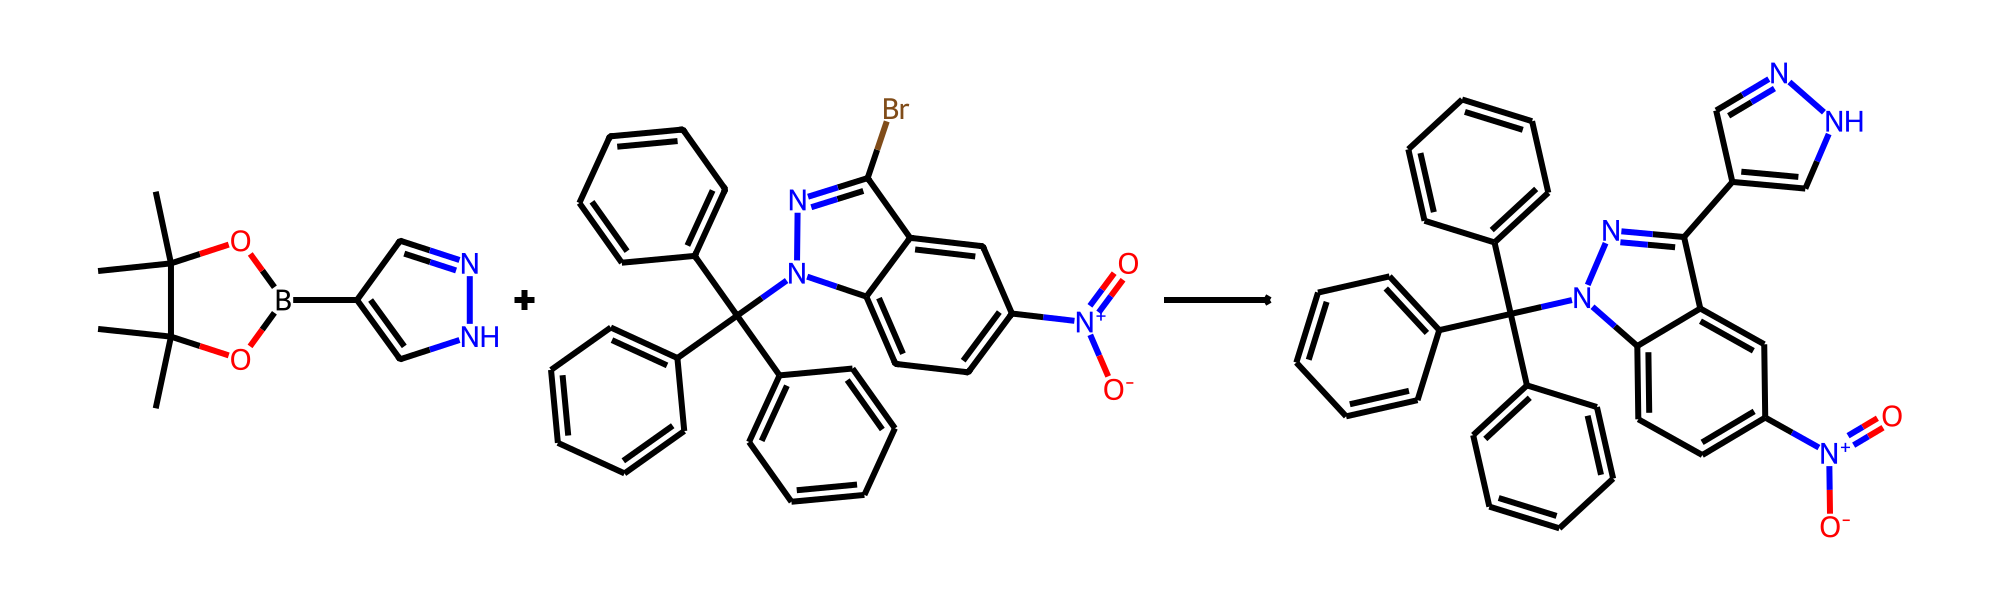

In [20]:
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
rv = ReactionVisualizer()
rv.visualize_reaction(filtered_data[20]['reactions'])

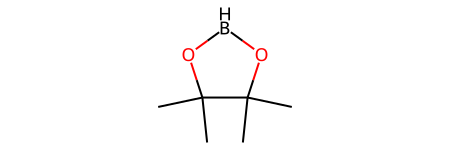

In [21]:
analyzer = MCSMissingGraphAnalyzer()
mcs_list, sorted_reactants, product_mol = analyzer.fit(filtered_data[20],  RingMatchesRingOnly=False, CompleteRingsOnly=False,
                                                       sort='MCS', remove_substructure=True)
impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
impute_product_frags[1]

In [23]:
def single_mcs(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True,
               sort='MCS', remove_substructure=True):
    """
    Performs mcs on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing mcs results and any sorted reactants encountered.
    """

    mcs_results_dict = {'mcs_results': [], 'sorted_reactants': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, _ = analyzer.fit(data_dict,  RingMatchesRingOnly=RingMatchesRingOnly, CompleteRingsOnly=CompleteRingsOnly,
                                                       sort=sort, remove_substructure=remove_substructure)
        mcs_results_dict['mcs_results'] = mcs_list
        mcs_results_dict['sorted_reactants'] = sorted_reactants

    except Exception as e:
        mcs_results_dict['issue'] = data_dict

    return mcs_results_dict

In [24]:
mcs_true = Parallel(n_jobs=-2)(delayed(single_mcs)(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True,
                                                     sort='MCS', remove_substructure=True) for data_dict in filtered_data[100:300])

[15:06:59] non-ring atom 2 marked aromatic
[15:06:59] non-ring atom 0 marked aromatic


In [25]:
pd.DataFrame(final_true)

,mcs_results,sorted_reactants,issue
0,[<rdkit.Chem.rdchem.Mol object at 0x17521ebd0>...,[<rdkit.Chem.rdchem.Mol object at 0x17521e8b0>...,[]
1,[<rdkit.Chem.rdchem.Mol object at 0x175ecd040>...,[<rdkit.Chem.rdchem.Mol object at 0x175ecd680>...,[]
2,[<rdkit.Chem.rdchem.Mol object at 0x175ec0770>...,[<rdkit.Chem.rdchem.Mol object at 0x175ed7a40>...,[]
3,[<rdkit.Chem.rdchem.Mol object at 0x175ee06d0>],[<rdkit.Chem.rdchem.Mol object at 0x175ee5900>],[]
4,[<rdkit.Chem.rdchem.Mol object at 0x175ec09f0>],[<rdkit.Chem.rdchem.Mol object at 0x175ec06d0>],[]
...,...,...,...
195,[<rdkit.Chem.rdchem.Mol object at 0x175efe540>...,[<rdkit.Chem.rdchem.Mol object at 0x17218bc70>...,[]
196,[<rdkit.Chem.rdchem.Mol object at 0x175efe8b0>],[<rdkit.Chem.rdchem.Mol object at 0x175ee5770>],[]
197,[<rdkit.Chem.rdchem.Mol object at 0x1721875e0>...,[<rdkit.Chem.rdchem.Mol object at 0x172187950>...,[]
198,[<rdkit.Chem.rdchem.Mol object at 0x175efe7c0>],[<rdkit.Chem.rdchem.Mol object at 0x175efe1d0>],[]


In [72]:
from rdkit import Chem
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

def single_impute(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True):
    """
    Performs imputation on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing imputation results and any issues encountered.
    """

    impute_dict = {'impute_product_smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, product_mol = analyzer.fit(data_dict, RingMatchesRingOnly=RingMatchesRingOnly, CompleteRingsOnly=CompleteRingsOnly)
        impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
        impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]

        impute_dict['impute_product_smiles'] = impute_product_smiles
        impute_dict['boundary_atoms_products'] = boundary_atoms_products
        impute_dict['nearest_neighbor_products'] = nearest_neighbor_products

    except Exception as e:
        impute_dict['issue'] = data_dict

    return impute_dict


In [73]:
final_true = Parallel(n_jobs=-2)(delayed(single_impute)(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True) for data_dict in filtered_data[100:300])

In [74]:
final_df = pd.DataFrame(final_true)
final_df.shape
final_df = final_df.applymap(lambda x: np.nan if x == [] else x)
final_df.dropna(subset = ['issue'])

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_59664/4177540268.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df = final_df.applymap(lambda x: np.nan if x == [] else x)


,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
197,NaN,NaN,NaN,"{'id': 'US20130296569A1', 'class': 4, 'reactio..."


In [27]:
final

NameError: name 'final' is not defined

In [11]:
save_database(final,'../Data/rebalanced_all.json.gz')

In [13]:
final_df = pd.DataFrame(final_true)
final_df.shape

(200, 4)

In [61]:
final_df

,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[],[],[],"{'id': 'US20100197908A1', 'class': 9, 'reactio..."
1,[],[],[],"{'id': 'US20090118284A1', 'class': 3, 'reactio..."


In [14]:
final_df = final_df.applymap(lambda x: np.nan if x == [] else x)
final_df.dropna(subset = ['issue'])

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_59664/1948677312.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df = final_df.applymap(lambda x: np.nan if x == [] else x)


In [15]:
final_df.dropna(subset = ['issue'])

,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,NaN,NaN,NaN,"{'id': 'US06329547B1', 'class': 3, 'reactions'..."
5,NaN,NaN,NaN,"{'id': 'US20120029187A1', 'class': 4, 'reactio..."
6,NaN,NaN,NaN,"{'id': 'US20150175617A1', 'class': 5, 'reactio..."
8,NaN,NaN,NaN,"{'id': 'US20150045368A1', 'class': 5, 'reactio..."
11,NaN,NaN,NaN,"{'id': 'US20110269738A1', 'class': 3, 'reactio..."
...,...,...,...,...
180,NaN,NaN,NaN,"{'id': 'US20150087585A1', 'class': 5, 'reactio..."
184,NaN,NaN,NaN,"{'id': 'US06281227B1', 'class': 5, 'reactions'..."
190,NaN,NaN,NaN,"{'id': 'US20100152155A1', 'class': 5, 'reactio..."
195,NaN,NaN,NaN,"{'id': 'US20100331306A1', 'class': 4, 'reactio..."


In [6]:
id = 1
input = 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'
input_df = pd.DataFrame([{'id': id, 'reactions': input}])
input_df

,id,reactions
0,1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...


In [8]:
process=RSMIProcessing(data = input_df, rsmi_col='reactions',parallel=True, n_jobs=-1, 
                       save_json= False,)
input_dict = process.data_splitter().to_dict('records')



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [9]:
decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


# **2. Streamlit deploy**

not complete

In [29]:
import streamlit as st
import pandas as pd
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import load_database

class RebalancingReaction:
    def __init__(self, rule_manager_pathname):
        self.rules = load_database(pathname=rule_manager_pathname)

    def process_reactions(self, input_data):
        if isinstance(input_data, str):
            input_data = [{'reactions': input_data}]
        elif isinstance(input_data, pd.DataFrame):
            if 'reactions' not in input_data.columns:
                raise ValueError("DataFrame must contain a 'reactions' column.")
        elif not isinstance(input_data, list):
            raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

        if isinstance(input_data, pd.DataFrame):
            input_data = input_data.rename(columns={'reactions': 'reactants'})

        process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=-1, save_json=False)
        input_dict = process.data_splitter().to_dict('records')

        decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                                  parallel=True, n_jobs=-1, verbose=1)
        react_dict, product_dict = decompose.data_decomposer()

        comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=-1)
        unbalance, diff_formula = comp.run_parallel()

        reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                     pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                     pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                    axis=1).to_dict(orient='records')

        imp = SyntheticRuleImputer(rule_dict=self.rules)
        dict_impute = imp.impute(missing_dict=reactions_clean[0:1])

        return dict_impute

# Create a Streamlit app
st.title("Reaction Rebalancing App")

# Sidebar
st.sidebar.header("Settings")
rule_manager_path = st.sidebar.text_input("Rule Manager Path:", "./Data/rule_manager.json.gz")
reaction_input = st.sidebar.text_area("Input Reaction:", "")
input_data_list = st.sidebar.text_area("Input Data (JSON format):", "")
input_data = []

if reaction_input:
    input_data.append({'reactions': reaction_input})

if input_data_list:
    input_data.extend(pd.read_json(input_data_list).to_dict('records'))

rebalancer = RebalancingReaction(rule_manager_path)

# Main content
if st.button("Process Reactions"):
    if not input_data:
        st.warning("Please provide reaction data.")
    else:
        result = rebalancer.process_reactions(input_data)
        st.subheader("Rebalanced Reaction:")
        st.write(result)

# Display the input data for reference
st.subheader("Input Data:")
st.write(input_data)


2023-11-26 22:48:59.457 
  command:

    streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/cheminfo/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
import pandas as pd
from SynRBL.SynExtract import RSMIProcessing, RSMIDecomposer, RSMIComparator
from SynRBL.SynRuleImpute import SyntheticRuleImputer
from SynRBL.rsmi_utils import load_database
from SynRBL.SynVis import ReactionVisualizer

def synthesize_reactions(input_data):
    if isinstance(input_data, str):
        input_data = [{'reactions': input_data}]
    elif isinstance(input_data, pd.DataFrame):
        if 'reactions' not in input_data.columns:
            raise ValueError("DataFrame must contain a 'reactions' column.")
        input_data = input_data.to_dict('records')
    elif not isinstance(input_data, list):
        raise ValueError("Input data must be a string, a list of dictionaries, or a DataFrame.")

    # Step 1: Process the input data
    process = RSMIProcessing(data=pd.DataFrame(input_data), rsmi_col='reactions', parallel=True, n_jobs=-1, save_json=False)
    input_dict = process.data_splitter().to_dict('records')

    # Step 2: Decompose the reactions
    decompose = RSMIDecomposer(smiles=None, data=input_dict, reactant_col='reactants', product_col='products',
                              parallel=True, n_jobs=-1, verbose=1)
    react_dict, product_dict = decompose.data_decomposer()

    # Step 3: Compare reactants and products
    comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=-1)
    unbalance, diff_formula = comp.run_parallel()

    # Step 4: Combine the results into a dictionary
    reactions_clean = pd.concat([pd.DataFrame(input_dict),
                                 pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                 pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})],
                                axis=1).to_dict(orient='records')

    # Step 5: Load rule database
    rules = load_database(pathname='./Data/rule_manager.json.gz')

    # Step 6: Impute missing data
    imp = SyntheticRuleImputer(rule_dict=rules)
    dict_impute = imp.impute(missing_dict=reactions_clean[0:1])

    return dict_impute

# Example with a list of dictionaries containing reaction SMILES
input_data_list = [{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
                   {'reactions': 'CC>>C[C@H](O)c1ccccc1'},
                   {'reactions': 'CCO>>C[C@H](O)c1ccccc1.CCO'}]
result_list = synthesize_reactions(input_data_list)
print(result_list)

# Example usage with the provided input data
visualizer = ReactionVisualizer(compare=True, orientation='vertical', figsize=(12, 6), label_position='above', dpi=300)
visualizer.plot_reactions(result_list[0]['reactions'], result_list[0]['new_reaction'])



In [24]:
# Example with a list of dictionaries containing reaction SMILES
input_data_list = [{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
                   {'reactions': 'CC>>C[C@H](O)c1ccccc1'},
                   {'reactions': 'CCO>>C[C@H](O)c1ccccc1.CCO'}]
result_list = synthesize_reactions(input_data_list)
print(result_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1', 'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1', 'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]', 'Unbalance': 'Products', 'Diff_formula': {'O': 1, 'H': 2, 'Q': 0}, 'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]'}]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [26]:
result_list[0]

{'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
 'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
 'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]',
 'Unbalance': 'Products',
 'Diff_formula': {'O': 1, 'H': 2, 'Q': 0},
 'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.[OH-].[H+]'}

In [25]:
from SynRBL.SynVis import ReactionVisualizer

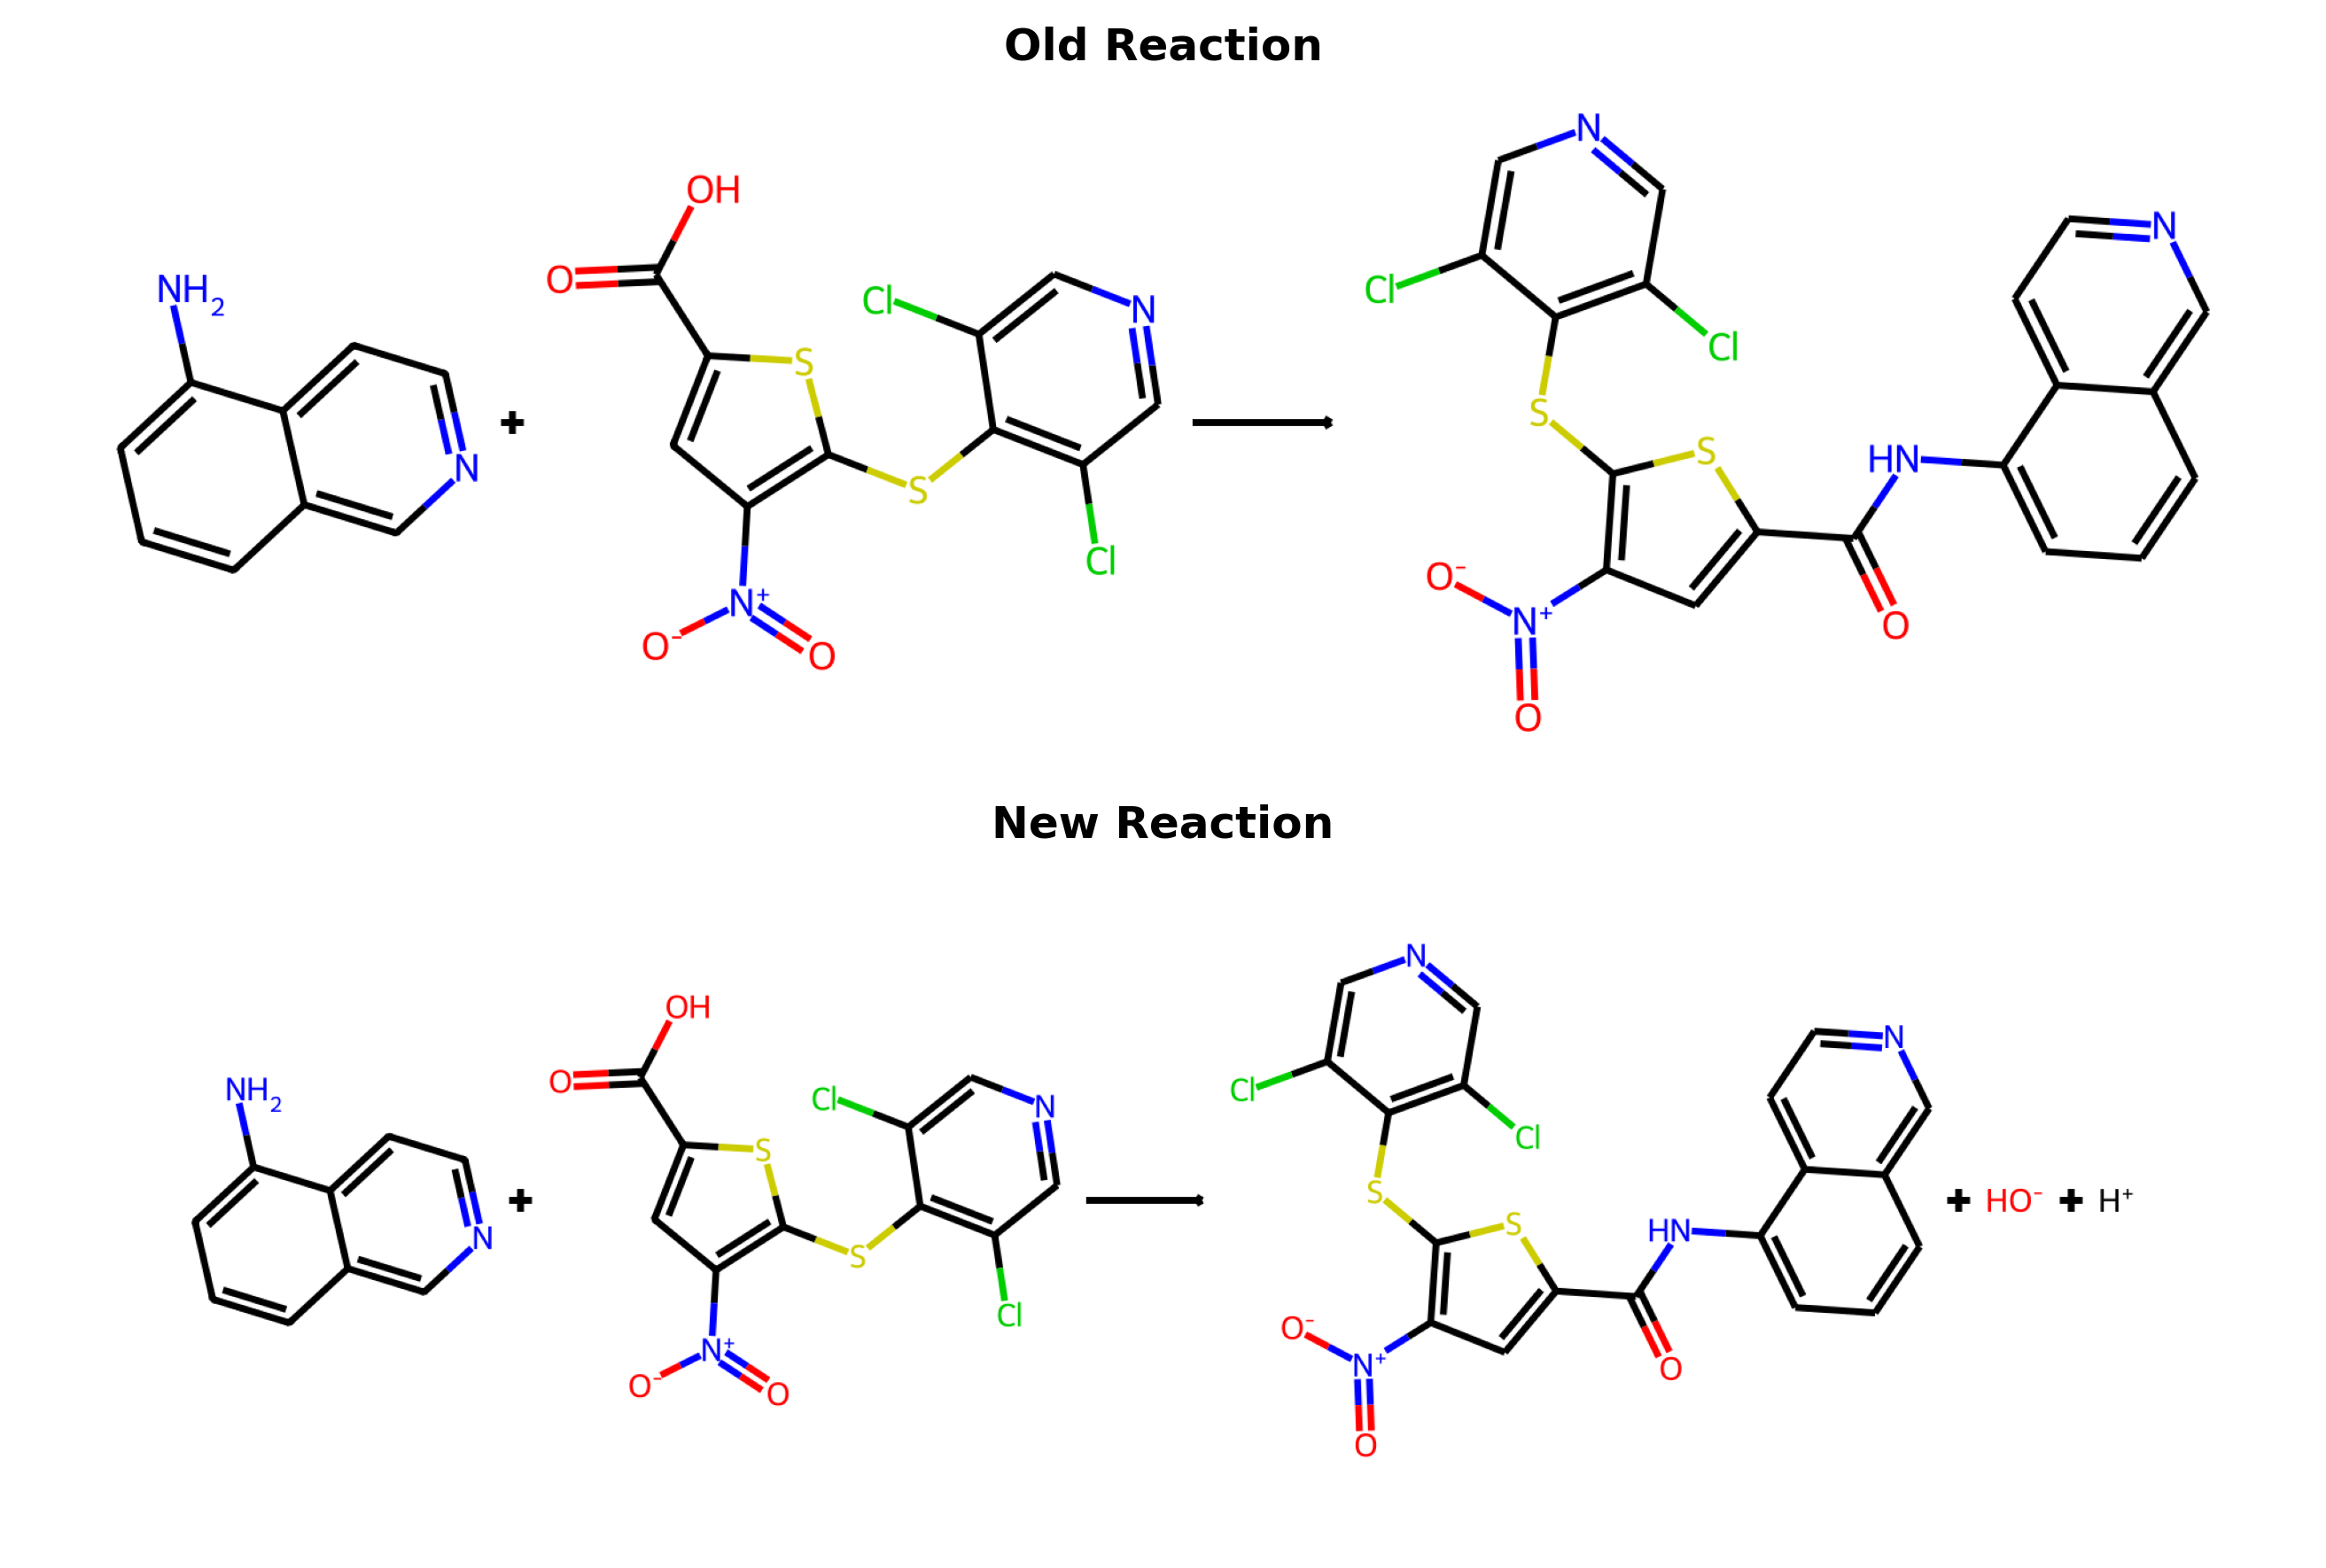

In [27]:
# Example usage with the provided input data
visualizer = ReactionVisualizer(compare=True, orientation='vertical', figsize=(12, 6), label_position='above', dpi=300)
visualizer.plot_reactions(result_list[0]['reactions'], result_list[0]['new_reaction'])


In [2]:
from rdkit import Chem

def is_mapping_correct(mol, symbol_to_index):
    # Convert the molecule to a dictionary of atom indices to symbols
    molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
    
    # Check if the mappings are consistent
    for symbol, index in symbol_to_index.items():
        if index not in molecule_dict:
            return False
        if molecule_dict[index] != symbol:
            return False
    
    return True

# Example usage:
mol = Chem.MolFromSmiles('CCO')  # Example molecule (ethanol)
symbol_to_index = {'C': 1, 'O': 1, 'H': 2}

if is_mapping_correct(mol, symbol_to_index):
    print("The mapping is correct.")
else:
    print("The mapping is not correct.")


The mapping is not correct.


In [126]:
import copy

# def map_parent_to_child(parent_mol, child_mol):
#     # Get atom indices in the parent molecule that match the entire child molecule
#     parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

#     # Create a mapping of parent atom indices to child atom indices
#     atom_mapping = {}
#     for child_idx, parent_idx in enumerate(parent_mcs_indices):
#         atom_mapping[parent_idx] = child_idx

#     return atom_mapping

def map_parent_to_child(parent_mol, child_mol, key_base):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        map_key = key_base[parent_idx]
        atom_mapping[map_key] = child_idx

    return atom_mapping

def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=True):
    """
    This function analyzes each molecule in a given list and identifies the parts that are not 
    present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
    atoms and nearest neighbors for each molecule.

    Parameters:
    - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
    - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
    corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
    - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
    - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

    Returns:
    Tuple containing:
    - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
    of each molecule, or None if no missing parts are found.
    - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
    - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
    """
    missing_parts_list = []
    boundary_atoms_lists = []
    nearest_neighbor_lists = []

    for mol, mcs_mol in zip(mol_list, mcs_list):
        atoms_to_remove = set()
        boundary_atoms_list = []
        nearest_neighbor_list = []
        #Chem.SanitizeMol(mcs_mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
        display(mcs_mol)
        if use_findMCS:
            # Calculate MCS using RDKit's rdFMCS
            display(mol)
            mcs = rdFMCS.FindMCS([mol, mcs_mol])
            mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            display(mcs_mol)
        
        try:
            if mcs_mol:
                # Special case handling (e.g., single oxygen atom)
                if Chem.MolToSmiles(mcs_mol) == 'O':
                    smarts_pattern = '[OH]'
                    smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                    substructure_match = mol.GetSubstructMatch(smarts_mol)
                    rw_mol = Chem.RWMol(mol)
                    rw_mol.RemoveAtom(substructure_match[0])
                    missing_part = rw_mol.GetMol()
                    boundary_atoms = [{'O': 0}]
                    nearest_atoms = [{'O': 0}]
                else:
                    raise ValueError
        except:
            if mcs_mol:
                # Finding substructure matches
                
                substructure_match = mol.GetSubstructMatch(mcs_mol)
                print(substructure_match)
                if substructure_match:
                    atoms_to_remove.update(substructure_match)
                #atoms_to_remove_list = {key: value for key, value in atoms_to_remove}
                
                #left_number = {key: value for key, value in substructure_match.items() if key not in atoms_to_remove_list}
                left_number = []
                for i in range(mol.GetNumAtoms()):
                    if i not in substructure_match:
                        left_number.append(i)
                
                
                print(left_number)
                # Creating the molecule of missing parts
                missing_part = Chem.RWMol(mol)
                for idx in sorted(atoms_to_remove, reverse=True):
                    missing_part.RemoveAtom(idx)
                missing_part_old = copy.deepcopy(missing_part)
                #print(missing_part_old.GetNumAtoms())
                display(missing_part)

                # re-index
                if missing_part is not None:
                #AM = False
                
                    missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                #try:
                    atom_mapping = map_parent_to_child(missing_part_old, missing_part, left_number)
                    print(atom_mapping)
                    #AM=True
                #except:
                #    pass
                # Mapping indices from original to missing part molecule
                else:
                    index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                boundary_atoms = []
                nearest_atoms = []

                # Identifying boundary atoms and nearest neighbors
                for atom_idx in substructure_match:
                    if atom_idx < mol.GetNumAtoms():
                        #display(draw_molecule_with_atom_numbers(mol))
                        #display(draw_molecule_with_atom_numbers(missing_part))
                        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                        neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                        # Loop through neighbors to find boundary atoms and nearest neighbors
                        for neighbor in neighbors:
                            if neighbor.GetIdx() not in substructure_match:
                                print(neighbor.GetIdx() )
                                nearest_atoms.append({atom_symbol: atom_idx})
                            
                                #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                if missing_part:
                                    renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                else:
                                    renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                if renumerate_idx != -1:
                                    boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

            if boundary_atoms:
                boundary_atoms_list.append(boundary_atoms)
            if nearest_atoms:
                nearest_neighbor_list.append(nearest_atoms)

        try:
            Chem.SanitizeMol(missing_part)
            if missing_part.GetNumAtoms() > 0:
                missing_parts_list.append(missing_part)
                boundary_atoms_lists.extend(boundary_atoms_list)
                nearest_neighbor_lists.extend(nearest_neighbor_list)
            else:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])
        except:
            #missing_parts_list.append(None)
            boundary_atoms_lists.extend([])
            nearest_neighbor_lists.extend([])

    return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists

In [ ]:
def map_parent_to_child(parent_mol, child_mol, key_base):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        map_key = key_base[parent_idx]
        atom_mapping[map_key] = child_idx

left_number = []
for i in range(mol.GetNumAtoms()):
    if i not in substructure_match:
        left_number.append(i)


In [ ]:
left_number = []
for i in range(mol.GetNumAtoms()):
    if i not in substructure_match:
        left_number.append(i)


In [118]:
def map_parent_to_child(key_compare, child_mol):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for key, value in enumerate():
        atom_mapping[parent_idx] = child_idx

    return atom_mapping


In [103]:
import sys
import pandas as pd
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
#from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from rdkit import Chem
#bug = load_database('../../Data/MCS/Bug.json.gz')
bug = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
#msc_df = pd.DataFrame(bug)

mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

In [104]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed

class FindMissingGraphs:
    """
    A class for finding missing parts, boundary atoms, and nearest neighbors in a list of reactant molecules.

    Usage:
    1. Create an instance of the class.
    2. Use the class methods to find missing parts, boundary atoms, and nearest neighbors for a list of molecules.

    Example:
    ```
    fm = FindMissingGraphs()
    missing_results = fm.find_single_graph(mcs_mol_list, sorted_reactants_mol_list)
    ```

    Note: This class requires the RDKit library to be installed.

    Attributes:
    None

    Methods:
    - find_missing_parts_pairs: Analyze a list of molecules and identify missing parts, boundary atoms, and nearest neighbors.
    - find_single_graph: Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules.
    - find_single_graph_parallel: Find missing parts, boundary atoms, and nearest neighbors in parallel for a list of reactant molecules.
    """

    def __init__(self):
        pass

    @staticmethod
    def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=False):
        """
        This function analyzes each molecule in a given list and identifies the parts that are not 
        present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
        atoms and nearest neighbors for each molecule.

        Parameters:
        - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
        corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
        - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
        - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

        Returns:
        Tuple containing:
        - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
        of each molecule, or None if no missing parts are found.
        - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
        - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
        """
        missing_parts_list = []
        boundary_atoms_lists = []
        nearest_neighbor_lists = []

        for mol, mcs_mol in zip(mol_list, mcs_list):
            atoms_to_remove = set()
            boundary_atoms_list = []
            nearest_neighbor_list = []
            #Chem.SanitizeMol(mcs_mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
            if use_findMCS:
                # Calculate MCS using RDKit's rdFMCS
                #params = rdFMCS.MCSParameters()
                #params.AtomTyper = rdFMCS.AtomCompare.CompareElements
                #params.BondTyper = rdFMCS.BondCompare.CompareOrder
                #params.Timeout = 60
                #params.BondCompareParameters.RingMatchesRingOnly = True
                #params.BondCompareParameters.CompleteRingsOnly = True

                mcs = rdFMCS.FindMCS([mol, mcs_mol])
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            #else:
                #atom_mapping = FindMissingGraphs.map_parent_to_child(mol, mcs_mol)
            
            try:
                if mcs_mol:
                    # Special case handling (e.g., single oxygen atom)
                    if Chem.MolToSmiles(mcs_mol) == 'O':
                        smarts_pattern = '[OH]'
                        smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                        substructure_match = mol.GetSubstructMatch(smarts_mol)
                        rw_mol = Chem.RWMol(mol)
                        rw_mol.RemoveAtom(substructure_match[0])
                        missing_part = rw_mol.GetMol()
                        boundary_atoms = [{'O': 0}]
                        nearest_atoms = [{'O': 0}]
                    else:
                        raise ValueError
            except:
                if mcs_mol:
                    #display(mcs_mol)
                    # Finding substructure matches
                    substructure_match = mol.GetSubstructMatch(mcs_mol)
                    if substructure_match:
                        atoms_to_remove.update(substructure_match)

                    # Creating the molecule of missing parts
                    missing_part = Chem.RWMol(mol)
                    for idx in sorted(atoms_to_remove, reverse=True):
                        missing_part.RemoveAtom(idx)

                    #display(missing_part)

                    # re-index
                    if missing_part is not None:
                    #AM = False
                    
                        missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                    #try:
                        atom_mapping = FindMissingGraphs.map_parent_to_child(mol, missing_part)
                        #AM=True
                    #except:
                    #    pass
                    # Mapping indices from original to missing part molecule
                    else:
                        index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                    boundary_atoms = []
                    nearest_atoms = []

                    # Identifying boundary atoms and nearest neighbors
                    for atom_idx in substructure_match:
                        if atom_idx < mol.GetNumAtoms():
                            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            # Loop through neighbors to find boundary atoms and nearest neighbors
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({atom_symbol: atom_idx})
                                    print(atom_mapping)
                                    print(neighbor.GetIdx())
                                    #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                    #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    if missing_part:
                                        renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    else:
                                        renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                    if renumerate_idx != -1:
                                        boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

                if boundary_atoms:
                    boundary_atoms_list.append(boundary_atoms)
                if nearest_atoms:
                    nearest_neighbor_list.append(nearest_atoms)

            try:
                Chem.SanitizeMol(missing_part)
                if missing_part.GetNumAtoms() > 0:
                    missing_parts_list.append(missing_part)
                    boundary_atoms_lists.extend(boundary_atoms_list)
                    nearest_neighbor_lists.extend(nearest_neighbor_list)
                else:
                    #missing_parts_list.append(None)
                    boundary_atoms_lists.extend([])
                    nearest_neighbor_lists.extend([])
            except:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])

        return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists
    

    @staticmethod
    def find_single_graph(mcs_mol_list, sorted_reactants_mol_list, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.

        Returns:
        - Dictionary containing:
        - 'smiles' (list of list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (list): Any issues encountered during processing.
        """
        missing_results = {'smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}
        for i in zip(sorted_reactants_mol_list, mcs_mol_list):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(i[0], i[1], use_findMCS=use_findMCS)
                missing_results['smiles'].append([Chem.MolToSmiles(mol) for mol in mols])
                missing_results['boundary_atoms_products'].append(boundary_atoms_products)
                missing_results['nearest_neighbor_products'].append(nearest_neighbor_products)
                missing_results['issue'].append([])
            except Exception as e:
                missing_results['smiles'].append([])
                missing_results['boundary_atoms_products'].append([])
                missing_results['nearest_neighbor_products'].append([])
                missing_results['issue'].append(str(e))
        return missing_results

    @staticmethod
    def find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=-1, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules in parallel.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - n_jobs (int): The number of parallel jobs to run. Default is -1, which uses all available CPU cores.

        Returns:
        - List of dictionaries, where each dictionary contains:
        - 'smiles' (list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (str): Any issues encountered during processing.
        """
        def process_single_pair(reactant_mol, mcs_mol, use_findMCS=True):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(reactant_mol, mcs_mol, use_findMCS=use_findMCS)
                return {
                    'smiles': [Chem.MolToSmiles(mol) for mol in mols],
                    'boundary_atoms_products': boundary_atoms_products,
                    'nearest_neighbor_products': nearest_neighbor_products,
                    'issue': ''
                }
            except Exception as e:
                return {
                    'smiles': [],
                    'boundary_atoms_products': [],
                    'nearest_neighbor_products': [],
                    'issue': str(e)
                }

        results = Parallel(n_jobs=n_jobs)(delayed(process_single_pair)(reactant_mol, mcs_mol, use_findMCS=use_findMCS) for reactant_mol, mcs_mol in zip(sorted_reactants_mol_list, mcs_mol_list))
        return results
    
    @staticmethod
    def map_parent_to_child(parent_mol, child_mol):
        # Get atom indices in the parent molecule that match the entire child molecule
        parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

        # Create a mapping of parent atom indices to child atom indices
        atom_mapping = {}
        for child_idx, parent_idx in enumerate(parent_mcs_indices):
            atom_mapping[parent_idx] = child_idx

        return atom_mapping

    @staticmethod
    def map_child_to_parent(child_mol, parent_mol):
        # Get atom indices in the child molecule that match the parent molecule
        child_mcs_indices = child_mol.GetSubstructMatch(parent_mol)

        # Create a mapping of child atom indices to parent atom indices
        atom_mapping = {}
        for parent_idx, child_idx in enumerate(child_mcs_indices):
            atom_mapping[child_idx] = parent_idx

        return atom_mapping
    
    @staticmethod
    def is_mapping_correct(mol, symbol_to_index):
        # Convert the molecule to a dictionary of atom indices to symbols
        molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
        
        # Check if the mappings are consistent
        for symbol, index in symbol_to_index.items():
            if index not in molecule_dict:
                return False
            if molecule_dict[index] != symbol:
                return False
        
        return True

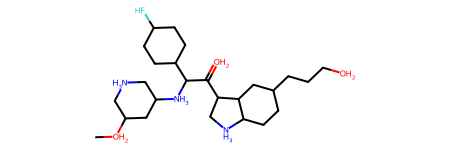

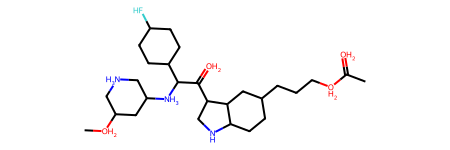

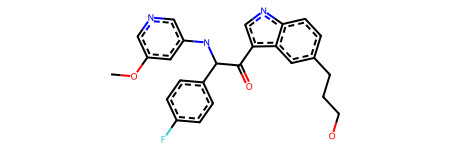

(0, 1, 2, 3, 4, 5, 6, 34, 7, 8, 9, 10, 11, 12, 13, 14, 26, 25, 17, 16, 15, 18, 19, 20, 21, 27, 28, 29, 30, 32, 33, 31)
[22, 23, 24]


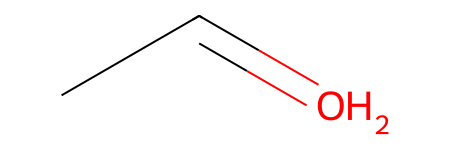

{23: 0, 22: 1, 24: 2}
22


([<rdkit.Chem.rdchem.Mol at 0x7f3c1945aac0>], [[{'C': 1}]], [[{'O': 21}]])

In [146]:
find_missing_parts_pairs(sorted_reactants_mol_list[7], mcs_mol_list[7], use_findMCS=True)

In [99]:
find = FindMissingGraphs()
missing_graph, boundary, neighbor = find.find_missing_parts_pairs(sorted_reactants_mol_list[7], mcs_mol_list[7], use_findMCS=True)

{8: 0, 9: 1, 10: 2}
22


In [100]:
boundary

[]

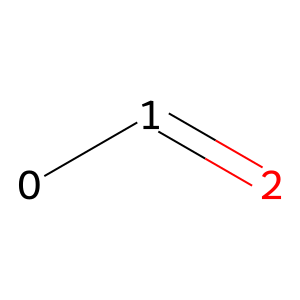

In [93]:
draw_molecule_with_atom_numbers(missing_graph[0])

In [59]:
from rdkit import Chem
from joblib import Parallel, delayed
from typing import List

def convert_smiles_to_mols(
    smiles_list: List[str]
    ) -> List[Chem.rdchem.Mol]:
    """
    Convert a list of SMILES strings to a list of RDKit molecule objects.

    Args:
        smiles_list: A list containing SMILES strings.

    Returns:
        A list containing RDKit molecule objects.
    """
    mol_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        # if mol:
        #     try:
        #         Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)
        #     except:
        #         pass
        # try:
        #     mol = Chem.RemoveHs(mol)   
        # except:
        #     mol = mol 
        mol_list.append(mol)
    return mol_list

def smiles_to_mol_parallel(
    smiles_lists: List[List[str]], 
    n_jobs: int = 4
    ) -> List[List[Chem.Mol]]:
    """
    Convert a list of lists of SMILES strings to a list of lists of RDKit molecule objects using parallel processing.

    :param smiles_lists: List of lists containing SMILES strings.
    :param n_jobs: The number of jobs to run in parallel. -1 means using all processors.
    :return: A list of lists containing RDKit molecule objects.
    """
    mol_lists = Parallel(n_jobs=n_jobs)(delayed(convert_smiles_to_mols)(smiles_list) for smiles_list in smiles_lists)
    return mol_lists


In [60]:
find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)
missing_final = pd.DataFrame(missing_results)

{0: 0}
0
{0: 0}
0
{0: 0, 1: 1, 2: 2, 3: 3}
3
{0: 0, 1: 1}
1
{}
4
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
5
{0: 0}
0
{0: 0, 1: 1}
1
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 48: 7, 49: 8}
6
{7: 0, 6: 1, 5: 2, 4: 3, 3: 4, 2: 5, 1: 6}
14
{0: 0, 1: 1}
34
{2: 0, 3: 1, 4: 2, 5: 3, 13: 4, 20: 5, 33: 6}
25
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 31: 7, 32: 8}
6
{0: 0, 1: 1}
1
{0: 0}
0
{8: 0, 9: 1, 10: 2}
22
{29: 0, 28: 1, 30: 2, 31: 3, 27: 4, 25: 5, 26: 6}
25
{}
7
{0: 0, 1: 1, 2: 2}{22: 0, 21: 1, 23: 2, 20: 3, 19: 4, 27: 5, 24: 6, 25: 7, 26: 8}

419

{0: 0, 1: 1, 2: 2}
1
{4: 0}
4
{16: 0, 15: 1, 17: 2, 14: 3, 13: 4, 21: 5, 18: 6, 19: 7, 20: 8}
13
{13: 0, 12: 1, 14: 2, 11: 3, 15: 4, 16: 5, 17: 6, 18: 7}
11
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
5
{0: 0, 1: 1, 2: 2, 3: 3, 12: 4, 13: 5, 15: 6}
5
{13: 0, 12: 1, 11: 2, 16: 3, 15: 4, 14: 5}
11
{19: 0, 18: 1, 20: 2}
18
{5: 0, 4: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8, 13: 9}
4
{7: 0, 6: 1, 8: 2}
6
{20: 0, 19: 1, 21: 2, 22: 3, 18: 4,

In [63]:
import numpy as np
missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
len(non_pass_df)

0

In [64]:
missing_final

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[C],[[{'C': 0}]],[[{'O': 1}]],NaN
1,[CC],[[{'C': 1}]],[[{'O': 2}]],NaN
2,[C[Si](C)C(C)(C)C],[],[[{'O': 7}]],NaN
3,[CC(C)(C)OC=O],[[{'C': 5}]],[[{'N': 7}]],NaN
4,[C],[[{'C': 0}]],[[{'O': 1}]],NaN
...,...,...,...,...
504,[O],[[{'O': 0}]],[[{'C': 1}]],NaN
505,[O],[[{'O': 0}]],[[{'C': 1}]],NaN
506,[O],[],[[{'C': 10}]],NaN
507,[O],[[{'O': 0}]],[[{'C': 1}]],NaN


In [77]:
ind_key = []
for key, value in enumerate(missing_final['boundary_atoms_products']):
    if len(value)==0:
        ind_key.append(key)

missing_final.iloc[ind_key,:]

In [80]:
missing_final.iloc[ind_key,:]

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
2,[C[Si](C)C(C)(C)C],[],[[{'O': 7}]],NaN
7,[CC=O],[],[[{'O': 21}]],NaN
12,[CC],[],[[{'O': 33}]],NaN
13,[Cc1ccccc1],[],[[{'N': 13}]],NaN
14,[Cc1ccccc1],[],[[{'N': 24}]],NaN
...,...,...,...,...
493,[O],[],[[{'C': 11}]],NaN
497,[O],[],[[{'C': 23}]],NaN
500,[O],[],[[{'C': 6}]],NaN
502,[O],[],[[{'C': 21}]],NaN


In [79]:
len(ind_key)

122

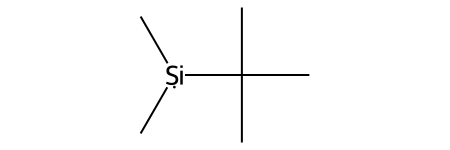

In [69]:
smi = 'C[Si](C)C(C)(C)C'
Chem.MolFromSmiles(smi)

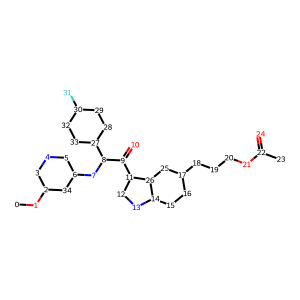

In [87]:
draw_molecule_with_atom_numbers(sorted_reactants_mol_list[7][0])

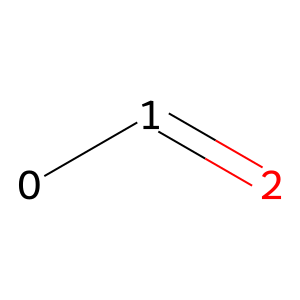

In [94]:
draw_molecule_with_atom_numbers(missing_graph[0])

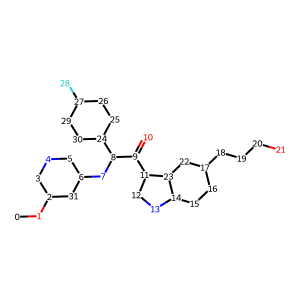

In [88]:
draw_molecule_with_atom_numbers(mcs_mol_list[7][0])

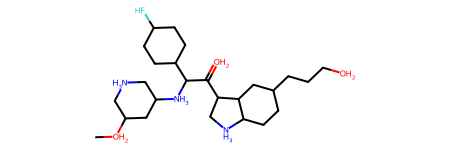

In [84]:
atom_mapping = find.map_parent_to_child(sorted_reactants_mol_list[7][0], mcs_mol_list[7][0])
atom_mapping

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 25: 22,
 26: 23,
 27: 24,
 28: 25,
 29: 26,
 30: 27,
 31: 28,
 32: 29,
 33: 30,
 34: 31}

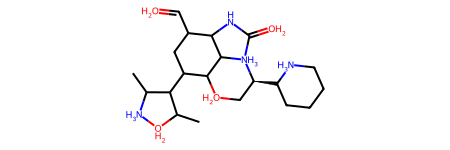

In [48]:
sorted_reactants_mol_list[506][0]

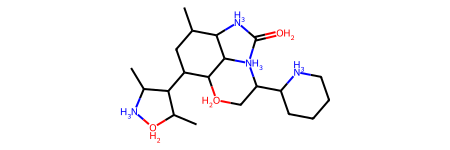

In [49]:
mcs_mol_list[506][0]

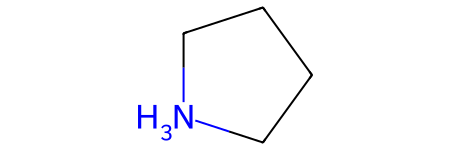

In [31]:
mcs_mol_list[504][1]

In [233]:
import numpy as np
missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
print('Bug:', len(non_pass_df))

Bug: 17


In [243]:
missing_final[missing_final['issue'].notnull()]

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
4,[],[],[],Python argument types in\n Mol.GetSubstruct...
5,[],[],[],Python argument types in\n Mol.GetSubstruct...
41,[],[],[],Python argument types in\n Mol.GetSubstruct...
85,[],[],[],Python argument types in\n Mol.GetSubstruct...
95,[],[],[],Python argument types in\n Mol.GetSubstruct...
107,[],[],[],Python argument types in\n Mol.GetSubstruct...
108,[],[],[],Python argument types in\n Mol.GetSubstruct...
120,[],[],[],Python argument types in\n Mol.GetSubstruct...
187,[],[],[],Python argument types in\n Mol.GetSubstruct...
307,[],[],[],Python argument types in\n Mol.GetSubstruct...


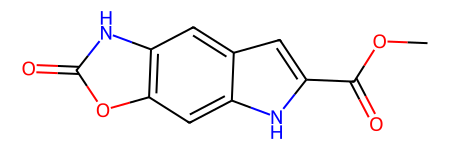

In [13]:
sorted_reactants_mol_list[4][0]

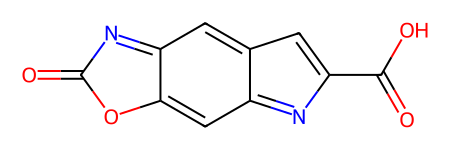

In [14]:
mcs_mol_list[4][0]

In [234]:
non_pass_df

[{'smiles': [],
  'boundary_atoms_products': [],
  'nearest_neighbor_products': [],
  'issue': 'Python argument types in\n    Mol.GetSubstructMatch(Mol, NoneType)\ndid not match C++ signature:\n    GetSubstructMatch(RDKit::ROMol self, RDKit::MolBundle query, RDKit::SubstructMatchParameters params)\n    GetSubstructMatch(RDKit::ROMol self, RDKit::ROMol query, RDKit::SubstructMatchParameters params)\n    GetSubstructMatch(RDKit::ROMol self, RDKit::MolBundle query, bool useChirality=False, bool useQueryQueryMatches=False)\n    GetSubstructMatch(RDKit::ROMol self, RDKit::ROMol query, bool useChirality=False, bool useQueryQueryMatches=False)'},
 {'smiles': [],
  'boundary_atoms_products': [],
  'nearest_neighbor_products': [],
  'issue': 'Python argument types in\n    Mol.GetSubstructMatch(Mol, NoneType)\ndid not match C++ signature:\n    GetSubstructMatch(RDKit::ROMol self, RDKit::MolBundle query, RDKit::SubstructMatchParameters params)\n    GetSubstructMatch(RDKit::ROMol self, RDKit::ROMo

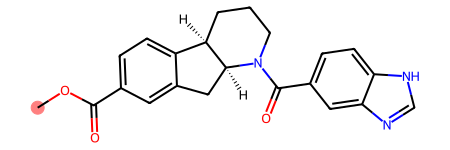

In [145]:
sorted_reactants_mol_list[0][0]

In [266]:
import sys
import pandas as pd
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from rdkit import Chem
bug = load_database('../../Data/MCS/Bug.json.gz')

msc_df = pd.DataFrame(bug)

mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

[10:54:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 27 28
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 8 9 11 14 15
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 22 23
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 20 21 22 34 35 36 37 47 48
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 31 32
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[10:54:23] Can't kekulize mol.  Unkekulized atoms: 6 7

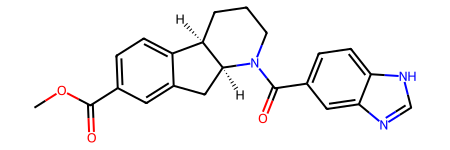

In [149]:
sorted_reactants_mol_list[0][0]

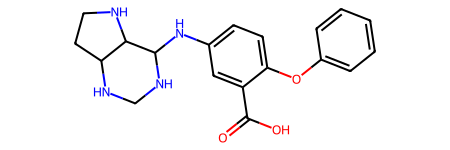

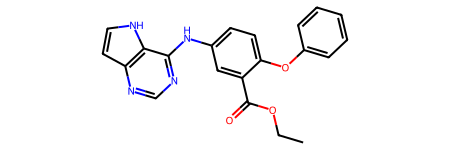

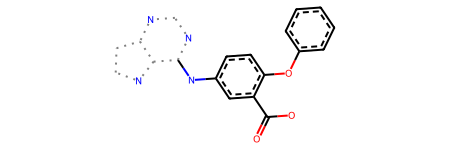

(4, 3, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 16, 15, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27)


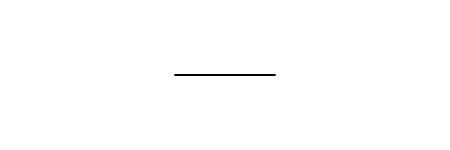

{0: 0, 1: 1}
1


([<rdkit.Chem.rdchem.Mol at 0x7f3c2cdcbba0>], [[{'C': 1}]], [[{'O': 2}]])

In [154]:
find_missing_parts_pairs(sorted_reactants_mol_list[1], mcs_mol_list[1])

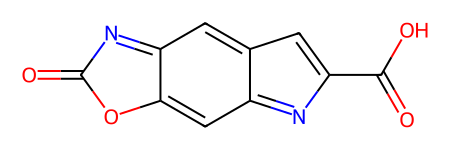

In [15]:
from rdkit.Chem import rdFMCS
mcs_mol =mcs_mol_list[4][0]
Chem.SanitizeMol(mcs_mol, Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)

#Chem.SanitizeMol(mcs_mol)

Chem.Kekulize(mcs_mol)
mcs_mol

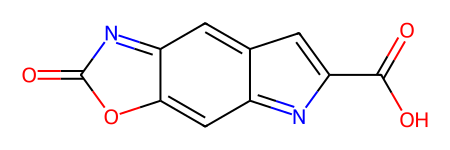

In [19]:
canonicalize_tautomer(mcs_mol)

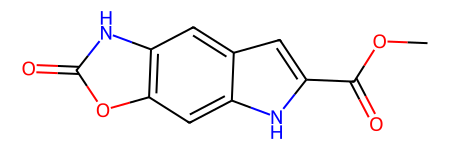

In [17]:
mol =sorted_reactants_mol_list[4][0]
Chem.Kekulize(mol)
mol

In [18]:
from rdkit.Chem.MolStandardize import normalize, tautomer
def canonicalize_tautomer(mol: Chem.Mol) -> Chem.Mol:
    """
    Canonicalize the tautomer of a molecule using RDKit's TautomerCanonicalizer.

    Args:
    - mol (Chem.Mol): RDKit Mol object.

    Returns:
    - Chem.Mol: Mol object with canonicalized tautomer.
    """
    return tautomer.TautomerCanonicalizer().canonicalize(mol)

In [264]:
params = rdFMCS.MCSParameters()
params.AtomTyper = rdFMCS.AtomCompare.CompareElements

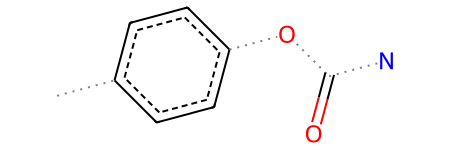

In [265]:
mcs = rdFMCS.FindMCS([mol, mcs_mol], params)
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_mol

In [251]:
atoms_to_remove = set()
substructure_match = mol.GetSubstructMatch(mcs_mol)
if substructure_match:
    atoms_to_remove.update(substructure_match)

# Creating the molecule of missing parts
missing_part = Chem.RWMol(mol)
for idx in sorted(atoms_to_remove, reverse=True):
    missing_part.RemoveAtom(idx)

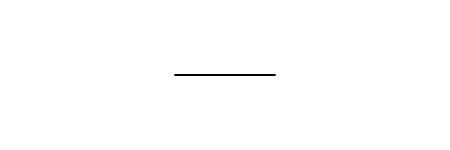

In [140]:
display(missing_part)

In [128]:
def map_parent_to_child(parent_mol, child_mol):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        atom_mapping[parent_idx] = child_idx

    return atom_mapping
atom_mapping = map_parent_to_child(mol, missing_part)
atom_mapping

{0: 0, 1: 1}

In [106]:
boundary_atoms = []
nearest_atoms = []

# Identifying boundary atoms and nearest neighbors
for atom_idx in substructure_match:
    if atom_idx < mol.GetNumAtoms():
        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
        neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
        # Loop through neighbors to find boundary atoms and nearest neighbors
        for neighbor in neighbors:
            if neighbor.GetIdx() not in substructure_match:
                nearest_atoms.append({atom_symbol: atom_idx})
                print(atom_idx)
            
                #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                if missing_part:
                     renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                # else:
                #     renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                if renumerate_idx != -1:
                     boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

2


In [107]:
boundary_atoms

[{'C': 1}]

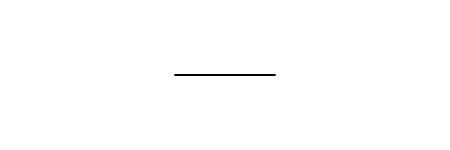

In [57]:
missing_part

In [59]:
def map_parent_to_child(parent_mol, child_mol):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        atom_mapping[parent_idx] = child_idx

    return atom_mapping


map_parent_to_child(mol, missing_part)

{0: 0, 1: 1}

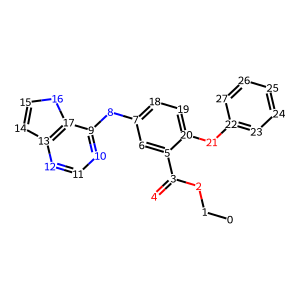

In [98]:
draw_molecule_with_atom_numbers(mol)

In [25]:
substructure_match = mol.GetSubstructMatch(mcs_mol)

In [26]:
substructure_match

()

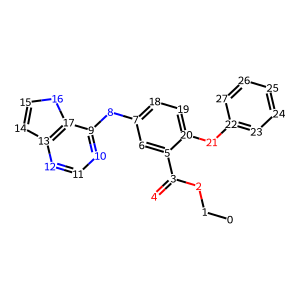

In [82]:
draw_molecule_with_atom_numbers(mol)

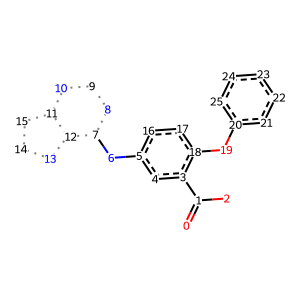

In [85]:
draw_molecule_with_atom_numbers(mcs_mol)

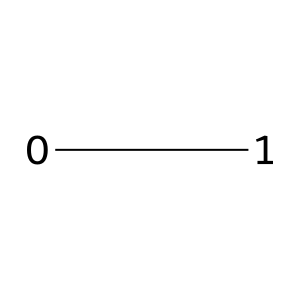

In [84]:
draw_molecule_with_atom_numbers(missing_part)

In [81]:

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list[0:1], sorted_reactants_mol_list[0:1], n_jobs=10, use_findMCS=True)
missing_final = pd.DataFrame(missing_results)


{0: 0}


In [73]:
missing_final

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[C],[[{'C': 0}]],[[{'O': 1}]],


In [85]:
from rdkit.Chem import Draw
def draw_molecule_with_atom_numbers(mol):
    """
    Draw a molecule with atom numbers annotated.
    
    :param mol: RDKit Molecule object.
    :return: An image of the molecule with atom numbers.
    """
    # Create a copy of the molecule
    mol_with_atom_numbers = Chem.Mol(mol)
    
    # Add atom numbers
    for atom in mol_with_atom_numbers.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    # Draw the molecule
    return Draw.MolToImage(mol_with_atom_numbers, size=(300, 300))

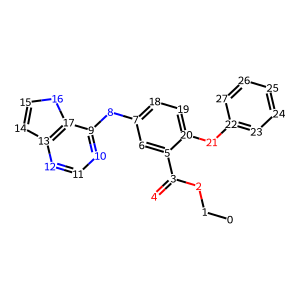

In [62]:
draw_molecule_with_atom_numbers(mol)

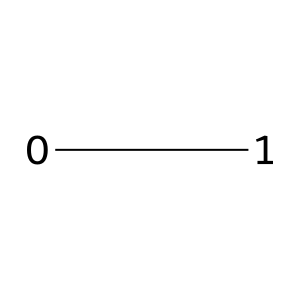

In [63]:
draw_molecule_with_atom_numbers(missing_part)

In [ ]:
def find_graph_dict(msc_dict_path: str,  save_path: str, save: bool =True,
                    n_jobs: int=4, use_findMCS: bool=True):
    """
    Function to find missing graphs for a given MCS dictionary.
    """
    mcs_dict = load_database(msc_dict_path)

    msc_df = pd.DataFrame(mcs_dict)

    mcs_results = msc_df['mcs_results'].to_list()
    sorted_reactants = msc_df['sorted_reactants'].to_list()

    mcs_mol_list = smiles_to_mol_parallel(mcs_results)
    sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

    find_graph = FindMissingGraphs()
    missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=n_jobs, use_findMCS=use_findMCS)
    missing_final = pd.DataFrame(missing_results)

    missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
    non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
    print('Bug:', len(non_pass_df))
    if save:
        save_database(missing_results, save_path)
    non_pass_df = msc_df.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
    
    return missing_results, non_pass_df



In [ ]:
def main():

    missing_results_3_macth, non_pass_df= find_graph_dict(msc_dict_path=f'{root_dir}/Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz',
                save_path=f'{root_dir}/Data/MCS/Final_Graph_macth_3+.json.gz')
    save_database(non_pass_df, root_dir / 'Data/MCS/Bug.json.gz')
    
    #missing_results_largest = find_graph_dict(msc_dict_path=f'{root_dir}/Data/MCS/Intersection_MCS_0_50_largest.json.gz',
    #            save_path=f'{root_dir}/Data/MCS/Final_Graph_macth_under2-.json.gz')
    
    

# Execute main function
if __name__ == "__main__":
    main()


# Test

In [267]:
import sys
import pandas as pd
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from rdkit import Chem
#bug = load_database('../../Data/MCS/Bug.json.gz')
bug = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
msc_df = pd.DataFrame(bug)

              
mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

In [5]:
mcs_dict = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')

msc_df = pd.DataFrame(mcs_dict)

mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)
missing_final = pd.DataFrame(missing_results)

missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
print('Bug:', len(non_pass_df))

NameError: name 'load_database' is not defined

In [4]:
def check_for_bug(dataframe):
    ind_key = []
    for key, value in enumerate(dataframe['boundary_atoms_products']):
        if len(value) == 0:
            ind_key.append(key)

    bug_rows = dataframe.iloc[ind_key, :]
    return bug_rows

bug_data = check_for_bug(missing_final)
print('Bug:', len(bug_data))

NameError: name 'missing_final' is not defined

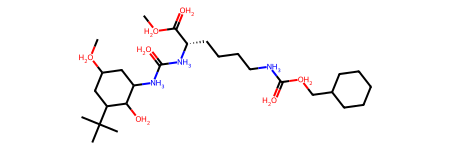

In [268]:
sorted_reactants_mol_list[0][0]

In [265]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed
from rdkit.Chem import rdmolops

class FindMissingGraphs:
    """
    A class for finding missing parts, boundary atoms, and nearest neighbors in a list of reactant molecules.

    Usage:
    1. Create an instance of the class.
    2. Use the class methods to find missing parts, boundary atoms, and nearest neighbors for a list of molecules.

    Example:
    ```
    fm = FindMissingGraphs()
    missing_results = fm.find_single_graph(mcs_mol_list, sorted_reactants_mol_list)
    ```

    Note: This class requires the RDKit library to be installed.

    Attributes:
    None

    Methods:
    - find_missing_parts_pairs: Analyze a list of molecules and identify missing parts, boundary atoms, and nearest neighbors.
    - find_single_graph: Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules.
    - find_single_graph_parallel: Find missing parts, boundary atoms, and nearest neighbors in parallel for a list of reactant molecules.
    """

    def __init__(self):
        pass

    @staticmethod
    def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=False, params=None):
        """
        This function analyzes each molecule in a given list and identifies the parts that are not 
        present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
        atoms and nearest neighbors for each molecule.

        Parameters:
        - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
        corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
        - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
        - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

        Returns:
        Tuple containing:
        - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
        of each molecule, or None if no missing parts are found.
        - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
        - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
        """
        missing_parts_list = []
        boundary_atoms_lists = []
        nearest_neighbor_lists = []

        for mol, mcs_mol in zip(mol_list, mcs_list):
            atoms_to_remove = set()
            boundary_atoms_list = []
            nearest_neighbor_list = []

            if use_findMCS:
                #Chem.SanitizeMol(mol)
                #Chem.SanitizeMol(mol)
                # Calculate MCS using RDKit's rdFMCS
                mcs = rdFMCS.FindMCS([mol, mcs_mol])
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
                
            
            try:
                if mcs_mol:
                    # Special case handling (e.g., single oxygen atom)
                    if Chem.MolToSmiles(mcs_mol) == 'O':
                        smarts_pattern = '[OH]'
                        smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                        substructure_match = mol.GetSubstructMatch(smarts_mol)
                        rw_mol = Chem.RWMol(mol)
                        rw_mol.RemoveAtom(substructure_match[0])
                        missing_part = rw_mol.GetMol()
                        boundary_atoms = [{'O': 0}]
                        nearest_atoms = [{'O': 0}]
                    else:
                        raise ValueError
            except:
                if mcs_mol:
                    # Finding substructure matches
                    substructure_match = mol.GetSubstructMatch(mcs_mol)
                    if substructure_match:
                        atoms_to_remove.update(substructure_match)

                    
                    left_number = []
                    for i in range(mol.GetNumAtoms()):
                        if i not in substructure_match:
                            left_number.append(i)

                    
                    # Creating the molecule of missing parts
                    missing_part = Chem.RWMol(mol)
                    for idx in sorted(atoms_to_remove, reverse=True):
                        missing_part.RemoveAtom(idx)


                    missing_part_old = copy.deepcopy(missing_part)
                   

                    if missing_part is not None:
                        missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                     
                        missing_part = FindMissingGraphs.add_hydrogens_to_radicals(missing_part)
                        atom_mapping = FindMissingGraphs.map_parent_to_child(missing_part_old, missing_part, left_number)
                        
                    
                    else:
                        index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                    boundary_atoms = []
                    nearest_atoms = []

                    # Identifying boundary atoms and nearest neighbors
                    for atom_idx in substructure_match:
                        #display(mol)
                        if atom_idx < mol.GetNumAtoms():
                            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            # Loop through neighbors to find boundary atoms and nearest neighbors
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({atom_symbol: atom_idx})
                                
                                    #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                    #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    if missing_part:
                                        renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    else:
                                        renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                    if renumerate_idx != -1:
                                        boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

                if boundary_atoms:
                    boundary_atoms_list.append(boundary_atoms)
                if nearest_atoms:
                    nearest_neighbor_list.append(nearest_atoms)

            try:
                Chem.SanitizeMol(missing_part)
                if missing_part.GetNumAtoms() > 0:
                    missing_parts_list.append(missing_part)
                    boundary_atoms_lists.extend(boundary_atoms_list)
                    nearest_neighbor_lists.extend(nearest_neighbor_list)
                else:
                    #missing_parts_list.append(None)
                    boundary_atoms_lists.extend([])
                    nearest_neighbor_lists.extend([])
            except:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])

        return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists
    

    @staticmethod
    def find_single_graph(mcs_mol_list, sorted_reactants_mol_list, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.

        Returns:
        - Dictionary containing:
        - 'smiles' (list of list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (list): Any issues encountered during processing.
        """
        missing_results = {'smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}
        for i in zip(sorted_reactants_mol_list, mcs_mol_list):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(i[0], i[1], use_findMCS=use_findMCS)
                missing_results['smiles'].append([Chem.MolToSmiles(mol) for mol in mols])
                missing_results['boundary_atoms_products'].append(boundary_atoms_products)
                missing_results['nearest_neighbor_products'].append(nearest_neighbor_products)
                missing_results['issue'].append([])
            except Exception as e:
                missing_results['smiles'].append([])
                missing_results['boundary_atoms_products'].append([])
                missing_results['nearest_neighbor_products'].append([])
                missing_results['issue'].append(str(e))
        return missing_results

    @staticmethod
    def find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=-1, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules in parallel.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - n_jobs (int): The number of parallel jobs to run. Default is -1, which uses all available CPU cores.

        Returns:
        - List of dictionaries, where each dictionary contains:
        - 'smiles' (list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (str): Any issues encountered during processing.
        """
        def process_single_pair(reactant_mol, mcs_mol, use_findMCS=True):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(reactant_mol, mcs_mol, use_findMCS=use_findMCS)
                return {
                    'smiles': [Chem.MolToSmiles(mol) for mol in mols],
                    'boundary_atoms_products': boundary_atoms_products,
                    'nearest_neighbor_products': nearest_neighbor_products,
                    'issue': ''
                }
            except Exception as e:
                return {
                    'smiles': [],
                    'boundary_atoms_products': [],
                    'nearest_neighbor_products': [],
                    'issue': str(e)
                }

        results = Parallel(n_jobs=n_jobs)(delayed(process_single_pair)(reactant_mol, mcs_mol, use_findMCS=use_findMCS) for reactant_mol, mcs_mol in zip(sorted_reactants_mol_list, mcs_mol_list))
        return results
    
 
    @staticmethod
    def map_parent_to_child(parent_mol, child_mol, key_base):
        # Get atom indices in the parent molecule that match the entire child molecule
        parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

        # Create a mapping of parent atom indices to child atom indices
        atom_mapping = {}
        for child_idx, parent_idx in enumerate(parent_mcs_indices):
            map_key = key_base[parent_idx]
            atom_mapping[map_key] = child_idx

        return atom_mapping
    
    @staticmethod
    def is_mapping_correct(mol, symbol_to_index):
        # Convert the molecule to a dictionary of atom indices to symbols
        molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
        
        # Check if the mappings are consistent
        for symbol, index in symbol_to_index.items():
            if index not in molecule_dict:
                return False
            if molecule_dict[index] != symbol:
                return False
        
        return True
    
    @staticmethod
    def add_hydrogens_to_radicals(mol: Chem.Mol) -> Chem.Mol:
        """
        Add hydrogen atoms to radical sites in a molecule.

        Args:
        - mol (Chem.Mol): RDKit molecule object.

        Returns:
        - Chem.Mol: The modified molecule with added hydrogens.
        """
        # Create a copy of the molecule
        mol_with_h = Chem.RWMol(mol)

        # Add explicit hydrogens (not necessary if they are already present in the input molecule)
        mol_with_h = rdmolops.AddHs(mol_with_h)

        # Find and process radical atoms
        for atom in mol_with_h.GetAtoms():
            num_radical_electrons = atom.GetNumRadicalElectrons()
            if num_radical_electrons > 0:
                atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                atom.SetNumRadicalElectrons(0)
        
        curate_mol = Chem.RemoveHs(mol_with_h)
        return curate_mol
    

In [266]:
find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)
missing_final = pd.DataFrame(missing_results)
missing_final


,smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[O=COCc1ccccc1],[[{'C': 1}]],[[{'N': 9}]],
1,"[CC1(C)OBOC1(C)C, Br]","[[{'B': 4}], [{'Br': 0}]]","[[{'C': 5}], [{'C': 13}]]",
2,[CC(C)C],[[{'C': 1}]],[[{'O': 4}]],
3,[COc1ccc(C)cc1],[[{'C': 6}]],[[{'N': 8}]],
4,[C],[[{'C': 0}]],[[{'O': 1}]],
...,...,...,...,...
17454,[O],[[{'O': 0}]],[[{'C': 8}]],
17455,[O],[[{'O': 0}]],[[{'C': 3}]],
17456,[O],[[{'O': 0}]],[[{'C': 1}]],
17457,[O],[[{'O': 0}]],[[{'C': 9}]],


In [254]:
test = missing_final.iloc[:,:]

In [255]:
test

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[O=COCc1ccccc1],[[{'C': 1}]],[[{'N': 9}]],NaN
1,"[CC1(C)OBOC1(C)C, Br]","[[{'B': 4}], [{'Br': 0}]]","[[{'C': 5}], [{'C': 13}]]",NaN
2,[CC(C)C],[[{'C': 1}]],[[{'O': 4}]],NaN
3,[COc1ccc(C)cc1],[[{'C': 6}]],[[{'N': 8}]],NaN
4,[C],[[{'C': 0}]],[[{'O': 1}]],NaN
...,...,...,...,...
17454,[O],[[{'O': 0}]],[[{'C': 8}]],NaN
17455,[O],[[{'O': 0}]],[[{'C': 3}]],NaN
17456,[O],[[{'O': 0}]],[[{'C': 1}]],NaN
17457,[O],[[{'O': 0}]],[[{'C': 9}]],NaN


In [260]:
check = []
for i in range(len(test)):
    smiles_list = test.loc[i, 'smiles']
    boundary_atoms_products = test.loc[i, 'boundary_atoms_products']
    #print(len(smiles_list), len(boundary_atoms_products))
    #for key, values in enumerate(smiles_list):
    all_conditions_met = all(is_mapping_correct(Chem.MolFromSmiles(smiles_list[key]), boundary_atoms_products[key][0]) for key in range(len(smiles_list)))
    #map = is_mapping_correct(Chem.MolFromSmiles(values), boundary_atoms_products[key][0])
    check.append(all_conditions_met)

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed
from rdkit.Chem import rdmolops
import copy
class FindMissingGraphs:
    """
    A class for finding missing parts, boundary atoms, and nearest neighbors in a list of reactant molecules.

    Usage:
    1. Create an instance of the class.
    2. Use the class methods to find missing parts, boundary atoms, and nearest neighbors for a list of molecules.

    Example:
    ```
    fm = FindMissingGraphs()
    missing_results = fm.find_single_graph(mcs_mol_list, sorted_reactants_mol_list)
    ```

    Note: This class requires the RDKit library to be installed.

    Attributes:
    None

    Methods:
    - find_missing_parts_pairs: Analyze a list of molecules and identify missing parts, boundary atoms, and nearest neighbors.
    - find_single_graph: Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules.
    - find_single_graph_parallel: Find missing parts, boundary atoms, and nearest neighbors in parallel for a list of reactant molecules.
    """

    def __init__(self):
        pass

    @staticmethod
    def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=False, params=None):
        """
        This function analyzes each molecule in a given list and identifies the parts that are not 
        present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
        atoms and nearest neighbors for each molecule.

        Parameters:
        - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
        corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
        - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
        - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

        Returns:
        Tuple containing:
        - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
        of each molecule, or None if no missing parts are found.
        - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
        - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
        """
        missing_parts_list = []
        boundary_atoms_lists = []
        nearest_neighbor_lists = []

        for mol, mcs_mol in zip(mol_list, mcs_list):
            atoms_to_remove = set()
            boundary_atoms_list = []
            nearest_neighbor_list = []

            if use_findMCS:
                #Chem.SanitizeMol(mol)
                #Chem.SanitizeMol(mol)
                # Calculate MCS using RDKit's rdFMCS
                mcs = rdFMCS.FindMCS([mol, mcs_mol])
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
                
            
            try:
                if mcs_mol:
                    # Special case handling (e.g., single oxygen atom)
                    if Chem.MolToSmiles(mcs_mol) == 'O':
                        smarts_pattern = '[OH]'
                        smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                        substructure_match = mol.GetSubstructMatch(smarts_mol)
                        rw_mol = Chem.RWMol(mol)
                        rw_mol.RemoveAtom(substructure_match[0])
                        missing_part = rw_mol.GetMol()
                        boundary_atoms = [{'O': 0}]
                        nearest_atoms = [{'O': 0}]
                    else:
                        raise ValueError
            except:
                if mcs_mol:
                    # Finding substructure matches
                    substructure_match = mol.GetSubstructMatch(mcs_mol)
                    if substructure_match:
                        atoms_to_remove.update(substructure_match)

                    
                    left_number = []
                    for i in range(mol.GetNumAtoms()):
                        if i not in substructure_match:
                            left_number.append(i)

                    
                    # Creating the molecule of missing parts
                    missing_part = Chem.RWMol(mol)
                    for idx in sorted(atoms_to_remove, reverse=True):
                        missing_part.RemoveAtom(idx)


                    missing_part_old = copy.deepcopy(missing_part)
                   

                    if missing_part is not None:
                        missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                     
                        missing_part = FindMissingGraphs.add_hydrogens_to_radicals(missing_part)
                        atom_mapping = FindMissingGraphs.map_parent_to_child(missing_part_old, missing_part, left_number)
                        
                    
                    else:
                        index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                    boundary_atoms = []
                    nearest_atoms = []

                    # Identifying boundary atoms and nearest neighbors
                    for atom_idx in substructure_match:
                        #display(mol)
                        if atom_idx < mol.GetNumAtoms():
                            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            # Loop through neighbors to find boundary atoms and nearest neighbors
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({atom_symbol: atom_idx})
                                
                                    #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                    #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    if missing_part:
                                        renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    else:
                                        renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                    if renumerate_idx != -1:
                                        boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

                if boundary_atoms:
                    boundary_atoms_list.append(boundary_atoms)
                if nearest_atoms:
                    nearest_neighbor_list.append(nearest_atoms)

            try:
                Chem.SanitizeMol(missing_part)
                if missing_part.GetNumAtoms() > 0:
                    missing_parts_list.append(missing_part)
                    boundary_atoms_lists.extend(boundary_atoms_list)
                    nearest_neighbor_lists.extend(nearest_neighbor_list)
                else:
                    #missing_parts_list.append(None)
                    boundary_atoms_lists.extend([])
                    nearest_neighbor_lists.extend([])
            except:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])

        return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists
    

    @staticmethod
    def find_single_graph(mcs_mol_list, sorted_reactants_mol_list, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.

        Returns:
        - Dictionary containing:
        - 'smiles' (list of list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (list): Any issues encountered during processing.
        """
        missing_results = {'smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}
        for i in zip(sorted_reactants_mol_list, mcs_mol_list):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(i[0], i[1], use_findMCS=use_findMCS)
                missing_results['smiles'].append([Chem.MolToSmiles(mol) for mol in mols])
                missing_results['boundary_atoms_products'].append(boundary_atoms_products)
                missing_results['nearest_neighbor_products'].append(nearest_neighbor_products)
                missing_results['issue'].append([])
            except Exception as e:
                missing_results['smiles'].append([])
                missing_results['boundary_atoms_products'].append([])
                missing_results['nearest_neighbor_products'].append([])
                missing_results['issue'].append(str(e))
        return missing_results

    @staticmethod
    def find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=-1, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules in parallel.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - n_jobs (int): The number of parallel jobs to run. Default is -1, which uses all available CPU cores.

        Returns:
        - List of dictionaries, where each dictionary contains:
        - 'smiles' (list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (str): Any issues encountered during processing.
        """
        def process_single_pair(reactant_mol, mcs_mol, use_findMCS=True):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(reactant_mol, mcs_mol, use_findMCS=use_findMCS)
                return {
                    'smiles': [Chem.MolToSmiles(mol) for mol in mols],
                    'boundary_atoms_products': boundary_atoms_products,
                    'nearest_neighbor_products': nearest_neighbor_products,
                    'issue': ''
                }
            except Exception as e:
                return {
                    'smiles': [],
                    'boundary_atoms_products': [],
                    'nearest_neighbor_products': [],
                    'issue': str(e)
                }

        results = Parallel(n_jobs=n_jobs)(delayed(process_single_pair)(reactant_mol, mcs_mol, use_findMCS=use_findMCS) for reactant_mol, mcs_mol in zip(sorted_reactants_mol_list, mcs_mol_list))
        return results
    
 
    @staticmethod
    def map_parent_to_child(parent_mol, child_mol, key_base):
        # Get atom indices in the parent molecule that match the entire child molecule
        parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

        # Create a mapping of parent atom indices to child atom indices
        atom_mapping = {}
        for child_idx, parent_idx in enumerate(parent_mcs_indices):
            map_key = key_base[parent_idx]
            atom_mapping[map_key] = child_idx

        return atom_mapping
    
    @staticmethod
    def is_mapping_correct(mol, symbol_to_index):
        # Convert the molecule to a dictionary of atom indices to symbols
        molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
        
        # Check if the mappings are consistent
        for symbol, index in symbol_to_index.items():
            if index not in molecule_dict:
                return False
            if molecule_dict[index] != symbol:
                return False
        
        return True
    
    @staticmethod
    def add_hydrogens_to_radicals(mol: Chem.Mol) -> Chem.Mol:
        """
        Add hydrogen atoms to radical sites in a molecule.

        Args:
        - mol (Chem.Mol): RDKit molecule object.

        Returns:
        - Chem.Mol: The modified molecule with added hydrogens.
        """
        # Create a copy of the molecule
        mol_with_h = Chem.RWMol(mol)

        # Add explicit hydrogens (not necessary if they are already present in the input molecule)
        mol_with_h = rdmolops.AddHs(mol_with_h)

        # Find and process radical atoms
        for atom in mol_with_h.GetAtoms():
            num_radical_electrons = atom.GetNumRadicalElectrons()
            if num_radical_electrons > 0:
                atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                atom.SetNumRadicalElectrons(0)
        
        curate_mol = Chem.RemoveHs(mol_with_h)
        return curate_mol
    

In [ ]:
find = FindMissingGraphs()
find=find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=True, params=None):

In [2]:
mol_list = sorted_reactants_mol_list[2035]

NameError: name 'sorted_reactants_mol_list' is not defined

In [261]:
len(check)

17459

In [ ]:
all_conditions_met = all(is_mapping_correct(Chem.MolFromSmiles(smiles_list[key]), boundary_atoms_products[key][0]) for key in range(len(smiles_list)))


In [244]:
def is_mapping_correct(mol, symbol_to_index):
    # Convert the molecule to a dictionary of atom indices to symbols
    molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
    
    # Check if the mappings are consistent
    for symbol, index in symbol_to_index.items():
        if index not in molecule_dict:
            return False
        if molecule_dict[index] != symbol:
            return False
    
    return True
is_mapping_correct(mol=Chem.MolFromSmiles('O=COCc1ccccc1'), symbol_to_index={'C': 1})
all_conditions_met = all(is_mapping_correct(Chem.MolFromSmiles(smiles_list[key]), boundary_atoms_products[key][0]) for key in range(len(smiles_list)))


True

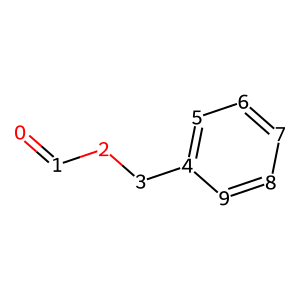

In [242]:
draw_molecule_with_atom_numbers(Chem.MolFromSmiles('O=COCc1ccccc1'))

In [223]:
sorted_reactants_mol_list[507][1]

IndexError: list index out of range

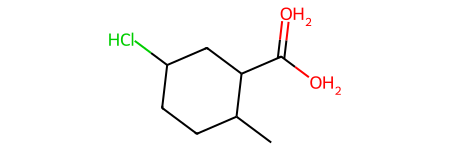

In [214]:
mcs_mol_list[507][1]

In [224]:
missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
print('Bug:', len(non_pass_df))

Bug: 0


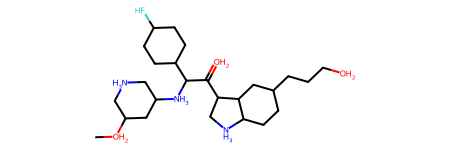

In [208]:
mcs_mol_list[7][0]

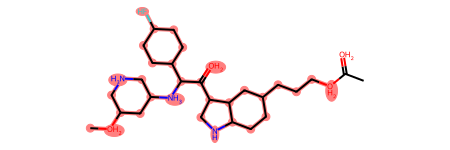

In [209]:
sorted_reactants_mol_list[7][0]

In [225]:
ind_key = []
for key, value in enumerate(missing_final['boundary_atoms_products']):
    if len(value)==0:
        ind_key.append(key)

missing_final.iloc[ind_key,:]

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
2305,[],[],[],NaN
4040,[],[],[],NaN


In [233]:
sorted_reactants_mol_list[4040][1]

IndexError: list index out of range

In [234]:
mcs_mol_list[4040][1]

IndexError: list index out of range

In [198]:
test = Chem.MolFromSmiles('O.[O-]')


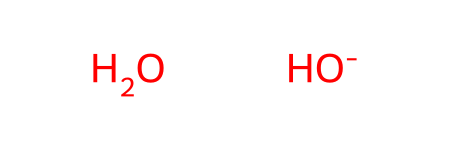

In [203]:
add_hydrogens_to_radicals(test)

In [202]:
from rdkit.Chem import rdmolops
def add_hydrogens_to_radicals(mol: Chem.Mol) -> Chem.Mol:
    """
    Add hydrogen atoms to radical sites in a molecule.

    Args:
    - mol (Chem.Mol): RDKit molecule object.

    Returns:
    - Chem.Mol: The modified molecule with added hydrogens.
    """
    # Create a copy of the molecule
    mol_with_h = Chem.RWMol(mol)

    # Add explicit hydrogens (not necessary if they are already present in the input molecule)
    mol_with_h = rdmolops.AddHs(mol_with_h)

    # Find and process radical atoms
    for atom in mol_with_h.GetAtoms():
        num_radical_electrons = atom.GetNumRadicalElectrons()
        if num_radical_electrons > 0:
            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
            atom.SetNumRadicalElectrons(0)
    
    curate_mol = Chem.RemoveHs(mol_with_h)
    return curate_mol

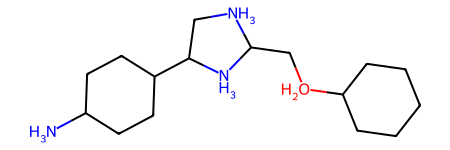

In [185]:
mcs_mol_list[434][0]

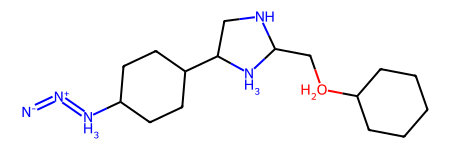

In [186]:
sorted_reactants_mol_list[434][0]